In [44]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Dataset


In [45]:
df = pd.read_csv(r"C:\Users\piyus\Desktop\CHE_657_FinalProject\Training_data.csv")
print("Dataset shape:", df.shape)
df.columns = [c.strip() for c in df.columns]
df = df.dropna(subset=["Meas DCN", "Meas MON", "Meas RON"], how='all')
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (431, 11)
Dataset shape: (430, 11)
             Compounds                SMILES  Pred DCN  Pred MON  Pred RON  \
1  2,3-dimethylpentane           CCC(C)C(C)C      21.3      91.7      95.9   
2           2-pentanol              CCCC(C)O      13.5      90.5      99.7   
3     methyl myristate  CCCCCCCCCCCCCC(=O)OC      76.1     -23.4     -12.3   
4   4-Methyl-1-pentene             C=CCC(C)C      21.0      80.3      94.9   
5             n-nonane             CCCCCCCCC      62.9     -11.0     -10.8   

  Meas DCN Meas MON Meas RON  AE DCN  AE MON  AE RON  
1     21.9     88.5     91.1     0.5     3.2     4.8  
2     n.a.     90.8     99.4     NaN     0.3     0.3  
3     75.8     n.a.     n.a.     0.3     NaN     NaN  
4     n.a.     80.9     95.7     NaN     0.6     0.8  
5     60.9     n.a.     n.a.     2.0     NaN     NaN  


## Compute Molecular Descriptors from SMILES

In [46]:
descriptor_names = [desc[0] for desc in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

def smiles_to_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [np.nan] * len(descriptor_names)
        return calculator.CalcDescriptors(mol)
    except:
        return [np.nan] * len(descriptor_names)

X_desc = df["SMILES"].apply(smiles_to_descriptors)
X = pd.DataFrame(X_desc.tolist(), columns=descriptor_names)

# Drop descriptors with missing values
X = X.dropna(axis=1)

print("Descriptors shape:", X.shape)
print(X)

Descriptors shape: (430, 217)
     MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0             2.296296        2.296296           0.865741        0.865741   
1             8.552361        8.552361           0.101852       -0.101852   
2            10.849922       10.849922           0.068589       -0.068589   
3             3.600833        3.600833           0.780093        0.780093   
4             2.263711        2.263711           1.367188        1.367188   
..                 ...             ...                ...             ...   
425          10.890929       10.890929           0.066599       -0.066599   
426           2.406250        2.406250           1.277778        1.277778   
427           2.290220        2.290220           1.372778        1.372778   
428          11.034398       11.034398           0.007966        0.007966   
429           3.550417        3.550417           1.152778        1.152778   

          qed        SPS    MolWt  HeavyAtomM

## Training & Validation

In [47]:
targets = ["Pred DCN", "Pred MON", "Pred RON"]
y = df[targets].apply(pd.to_numeric, errors='coerce')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(344, 217) (86, 217) (344, 3) (86, 3)


## Model Training

In [48]:
model = RandomForestRegressor(n_estimators=300,random_state=42,n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

## Evaluate Model

In [49]:
y_pred = pd.DataFrame(model.predict(X_val), columns=targets)
print('Pred Performance on validation')
for col in targets:
    mae = mean_absolute_error(y_val[col], y_pred[col])
    rmse = np.sqrt(mean_squared_error(y_val[col], y_pred[col]))
    r2 = r2_score(y_val[col], y_pred[col])
    print(f"\n {col} Performance:")
    print(f"MAE  = {mae:.3f}")
    print(f"RMSE = {rmse:.3f}")
    print(f"R²   = {r2:.3f}")

Pred Performance on validation

 Pred DCN Performance:
MAE  = 6.190
RMSE = 11.518
R²   = 0.709

 Pred MON Performance:
MAE  = 9.739
RMSE = 14.559
R²   = 0.859

 Pred RON Performance:
MAE  = 8.730
RMSE = 13.476
R²   = 0.885


## Plots

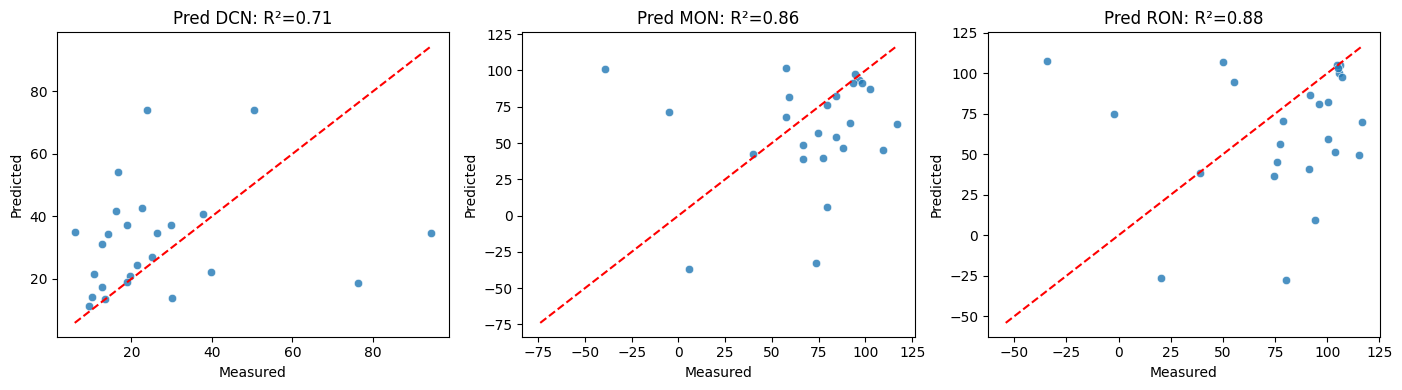

In [50]:
plt.figure(figsize=(14, 4))
for i, col in enumerate(targets):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=y_val[col], y=y_pred[col], alpha=0.8)
    plt.plot([y_val[col].min(), y_val[col].max()],
             [y_val[col].min(), y_val[col].max()], 'r--')
    plt.xlabel("Measured")
    plt.ylabel("Predicted")
    plt.title(f"{col}: R²={r2_score(y_val[col], y_pred[col]):.2f}")
plt.tight_layout()
plt.show()

In [51]:
df1=df
df1 = df1.dropna( how='any')
df1.shape

cols = ['Meas DCN', 'Pred DCN', 'Meas MON', 'Pred MON', 'Meas RON', 'Pred RON']
for c in cols:
    df1[c] = pd.to_numeric(df1[c], errors='coerce')
df1 = df1.dropna(subset=cols)
df1.shape

C:\Users\piyus\AppData\Local\Temp\ipykernel_14484\732080552.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[c] = pd.to_numeric(df1[c], errors='coerce')


(57, 11)

## Outlier removal using IQR method

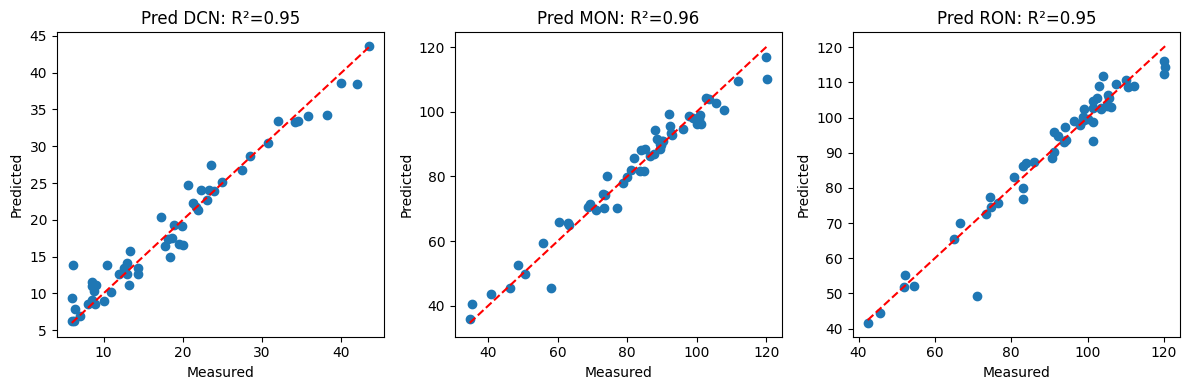

In [52]:

def remove_outliers_iqr(dataf, colum1, colum2):
    combined = pd.DataFrame({colum1: dataf[colum1], colum2: dataf[colum2]})
    Q1 = combined.quantile(0.25)
    Q3 = combined.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((combined < (Q1 - 1.5 * IQR)) | (combined > (Q3 + 1.5 * IQR))).any(axis=1)
    return dataf[mask]

df_clean_dcn = remove_outliers_iqr(df1, 'Meas DCN', 'Pred DCN')
df_clean_mon = remove_outliers_iqr(df1, 'Meas MON', 'Pred MON')
df_clean_ron = remove_outliers_iqr(df1, 'Meas RON', 'Pred RON')

def plot_pred_vs_measured(ax, measured, predicted, title):
    r2 = r2_score(measured, predicted)
    ax.scatter(measured, predicted)
    ax.plot([measured.min(), measured.max()], [measured.min(), measured.max()], 'r--')
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{title}: R²={r2:.2f}')

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_pred_vs_measured(axs[0], df_clean_dcn['Meas DCN'], df_clean_dcn['Pred DCN'], 'Pred DCN')
plot_pred_vs_measured(axs[1], df_clean_mon['Meas MON'], df_clean_mon['Pred MON'], 'Pred MON')
plot_pred_vs_measured(axs[2], df_clean_ron['Meas RON'], df_clean_ron['Pred RON'], 'Pred RON')
plt.tight_layout()
plt.show()


## Test

In [53]:
test_df = pd.read_csv(r"C:\Users\piyus\Desktop\CHE_657_FinalProject\Test_data.csv")
print("Dataset shape:", test_df.shape)
# Clean column names (remove spaces)
test_df.columns = [c.strip() for c in test_df.columns]
test_df = test_df.dropna(subset=["Meas DCN", "Meas MON", "Meas RON"], how='all')
print("Dataset shape:", test_df.shape)
print(test_df.head())

Dataset shape: (75, 11)
Dataset shape: (75, 11)
                   Compounds              SMILES  Pred DCN  Pred MON  \
0            δ-undecalactone  CCCCCCC1CCCC(=O)O1      47.1      23.9   
1  3,4,4-Trimethyl-2-pentene   C/C=C(\C)C(C)(C)C      12.6      85.3   
2     2,3-Dimethyl-2-pentene        CCC(C)=C(C)C      16.3      80.5   
3             2-methyl furan            Cc1ccco1       8.9      96.8   
4         Methylcyclopropane              CC1CC1      15.0      87.5   

   Pred RON Meas DCN Meas MON Meas RON  AE DCN  AE MON  AE RON  
0      29.2     48.6     n.a.     n.a.     1.5     NaN     NaN  
1     102.4     n.a.     86.1      103     NaN     0.8     0.6  
2      95.8     n.a.       80     97.5     NaN     0.5     1.7  
3     107.2        9       86      103     0.1    10.8     4.2  
4     107.1     n.a.     81.2    102.5     NaN     6.3     4.6  


## Compute Molecular Descriptors from SMILES

In [54]:
descriptor_names = [desc[0] for desc in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

def smiles_to_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [np.nan] * len(descriptor_names)
        return calculator.CalcDescriptors(mol)
    except:
        return [np.nan] * len(descriptor_names)

X_desc_ = test_df["SMILES"].apply(smiles_to_descriptors)
X_test = pd.DataFrame(X_desc_.tolist(), columns=descriptor_names)

X_test = X_test.dropna(axis=1)

print("Descriptors shape:", X_test.shape)
print(X_test)

Descriptors shape: (75, 217)
    MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0           10.940111       10.940111           0.006242        0.006242   
1            2.224537        2.224537           0.369792        0.369792   
2            2.182870        2.182870           1.196759        1.196759   
3            4.833333        4.833333           0.967593        0.967593   
4            2.277778        2.277778           1.083333        1.083333   
..                ...             ...                ...             ...   
70          10.917874       10.917874           0.440694        0.440694   
71           2.225139        2.225139           1.233472        1.233472   
72           3.724167        3.724167           0.993056        0.993056   
73           5.356481        5.356481           0.670139        0.670139   
74           8.629773        8.629773           0.329353        0.329353   

         qed        SPS    MolWt  HeavyAtomMolWt  ExactMol

In [55]:
y_test = test_df[targets].apply(pd.to_numeric, errors='coerce')
y_test

,Pred DCN,Pred MON,Pred RON
0,47.1,23.9,29.2
1,12.6,85.3,102.4
2,16.3,80.5,95.8
3,8.9,96.8,107.2
4,15.0,87.5,107.1
...,...,...,...
70,41.3,46.3,41.4
71,10.7,89.7,99.9
72,30.3,58.3,68.5
73,70.2,35.7,41.1


## Evaluate Model

In [56]:
y_pred_test = pd.DataFrame(model.predict(X_test), columns=targets)

print('Pred Performance on test')
for col in targets:
    mae = mean_absolute_error(y_test[col], y_pred_test[col])
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred_test[col]))
    r2 = r2_score(y_test[col], y_pred_test[col])
    print(f"\n {col} Performance:")
    print(f"MAE  = {mae:.3f}")
    print(f"RMSE = {rmse:.3f}")
    print(f"R²   = {r2:.3f}")

Pred Performance on test

 Pred DCN Performance:
MAE  = 4.956
RMSE = 10.457
R²   = 0.702

 Pred MON Performance:
MAE  = 7.571
RMSE = 13.305
R²   = 0.840

 Pred RON Performance:
MAE  = 7.583
RMSE = 12.637
R²   = 0.872


## Plots

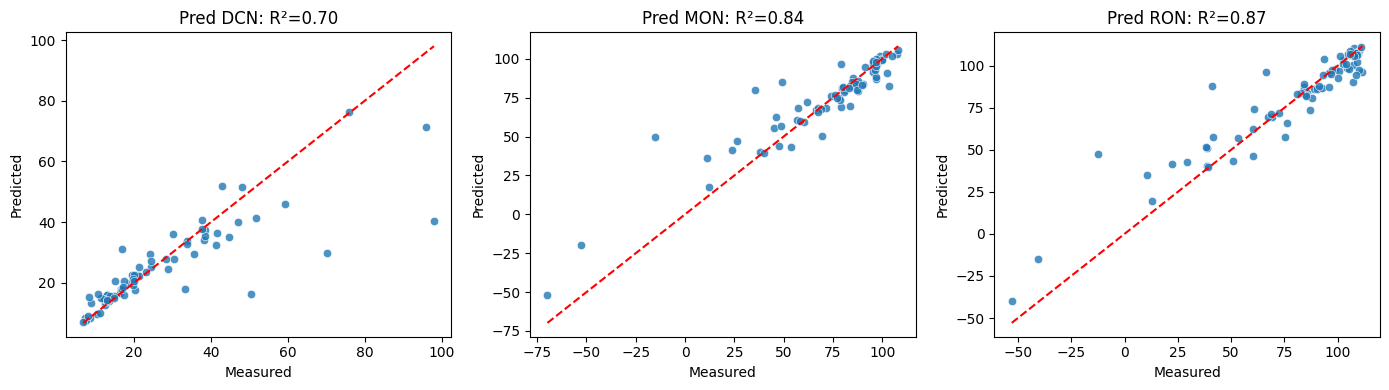

In [57]:
plt.figure(figsize=(14, 4))
for i, col in enumerate(targets):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=y_test[col], y=y_pred_test[col], alpha=0.8)
    plt.plot([y_test[col].min(), y_test[col].max()],
             [y_test[col].min(), y_test[col].max()], 'r--')
    plt.xlabel("Measured")
    plt.ylabel("Predicted")
    plt.title(f"{col}: R²={r2_score(y_test[col], y_pred_test[col]):.2f}")
plt.tight_layout()
plt.show()

### Regression impute vs KNN impute


In [58]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer

df[['Meas DCN', 'Meas MON', 'Meas RON']] = (
    df[['Meas DCN', 'Meas MON', 'Meas RON']]
    .replace(['n.a.', 'NA', 'Na', 'na', 'null', '--', 'N/A'], np.nan)
    .apply(pd.to_numeric, errors='coerce')
)

def regression_imputation(df):
    df_reg = df.copy()
    targets = ['Meas DCN', 'Meas MON', 'Meas RON']
    
    for target in targets:
        predictors = [t for t in targets if t != target]
        subset = df_reg.dropna(subset=predictors)
        train = subset.dropna(subset=[target])
        if train.empty:
            continue
        
        X_train = train[predictors]
        y_train = train[target]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        missing_mask = subset[target].isna()
        if missing_mask.any():
            X_missing = subset.loc[missing_mask, predictors]
            df_reg.loc[X_missing.index, target] = model.predict(X_missing)
    
    return df_reg
def knn_imputation(df, n_neighbors=5):
    df_knn = df.copy()
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_knn[['Meas DCN', 'Meas MON', 'Meas RON']] = imputer.fit_transform(
        df_knn[['Meas DCN', 'Meas MON', 'Meas RON']]
    )
    return df_knn
    
def compare_imputations(df_original):
    df_reg = regression_imputation(df_original)
    df_knn = knn_imputation(df_original)

    print("\n Missing values after Regression-based Imputation:")
    print(df_reg[['Meas DCN','Meas MON','Meas RON']].isna().sum())

    print("\n Missing values after KNN-based Imputation:")
    print(df_knn[['Meas DCN','Meas MON','Meas RON']].isna().sum())

    return df_reg, df_knn

df_reg, df_knn = compare_imputations(df)



 Missing values after Regression-based Imputation:
Meas DCN     18
Meas MON    160
Meas RON    146
dtype: int64

 Missing values after KNN-based Imputation:
Meas DCN    0
Meas MON    0
Meas RON    0
dtype: int64


In [59]:
def train_and_evaluate(df_input, label):
    
    df_model = df_input.dropna(subset=["Meas DCN", "Meas MON", "Meas RON"], how='any')
    
    X_desc = df_model["SMILES"].apply(smiles_to_descriptors)
    X = pd.DataFrame(X_desc.tolist(), columns=descriptor_names)
    X = X.dropna(axis=1)
    
    targets = ["Meas DCN", "Meas MON", "Meas RON"]
    y = df_model[targets].apply(pd.to_numeric, errors='coerce')

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    mask = ~y.isna().any(axis=1)
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = pd.DataFrame(model.predict(X_val), columns=targets)

    print("Performance on Validation Set:")
    for col in targets:
        mae = mean_absolute_error(y_val[col], y_pred[col])
        rmse = np.sqrt(mean_squared_error(y_val[col], y_pred[col]))
        r2 = r2_score(y_val[col], y_pred[col])
        print(f"\n{col}:")
        print(f" MAE  = {mae:.3f}")
        print(f" RMSE = {rmse:.3f}")
        print(f" R²   = {r2:.3f}")


In [60]:
train_and_evaluate(df_reg, "Regression-Imputed")
train_and_evaluate(df_knn, "KNN-Imputed")


Performance on Validation Set:

Meas DCN:
 MAE  = 4.211
 RMSE = 6.182
 R²   = 0.778

Meas MON:
 MAE  = 8.370
 RMSE = 11.853
 R²   = 0.765

Meas RON:
 MAE  = 7.874
 RMSE = 12.177
 R²   = 0.809
Performance on Validation Set:

Meas DCN:
 MAE  = 7.173
 RMSE = 12.850
 R²   = 0.669

Meas MON:
 MAE  = 11.107
 RMSE = 15.300
 R²   = 0.716

Meas RON:
 MAE  = 11.735
 RMSE = 16.248
 R²   = 0.757


In [61]:
missing_before = df[['Meas DCN', 'Meas MON', 'Meas RON']].isna().sum()
missing_after  = df_reg[['Meas DCN', 'Meas MON', 'Meas RON']].isna().sum()

missing_comparison = pd.DataFrame({
    'Missing Before': missing_before,
    'Missing After (Regression-Imputed)': missing_after
})

missing_comparison['% Reduction'] = (
    100 * (missing_comparison['Missing Before'] - missing_comparison['Missing After (Regression-Imputed)'])
    / missing_comparison['Missing Before']
).round(2)

print("Missing Value Comparison (Before vs Regression Imputed):")
display(missing_comparison)


Missing Value Comparison (Before vs Regression Imputed):


,Missing Before,Missing After (Regression-Imputed),% Reduction
Meas DCN,226,18,92.04
Meas MON,163,160,1.84
Meas RON,146,146,0.00


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def train_random_forest(df_input, label="Regression-Imputed"):

    df_model = df_input.dropna(subset=["Meas DCN", "Meas MON", "Meas RON"], how='any')

    X_desc = df_model["SMILES"].apply(smiles_to_descriptors)
    X = pd.DataFrame(X_desc.tolist(), columns=descriptor_names).dropna(axis=1)

    targets = ["Meas DCN", "Meas MON", "Meas RON"]
    y = df_model[targets].apply(pd.to_numeric, errors='coerce')

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    mask = ~y.isna().any(axis=1)
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    y_pred = pd.DataFrame(model.predict(X_test), columns=targets)

    print("Model Performance (Regression-Imputed Dataset):")
    for col in targets:
        mae = mean_absolute_error(y_test[col], y_pred[col])
        rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[col]))
        r2 = r2_score(y_test[col], y_pred[col])
        print(f"\n{col}:")
        print(f" MAE  = {mae:.3f}")
        print(f" RMSE = {rmse:.3f}")
        print(f" R²   = {r2:.3f}")

    return model, X_test, y_test, y_pred

final_model, X_test, y_test, y_pred = train_random_forest(df_reg, "Regression-Imputed (Final Model)")


Model Performance (Regression-Imputed Dataset):

Meas DCN:
 MAE  = 4.211
 RMSE = 6.182
 R²   = 0.778

Meas MON:
 MAE  = 8.370
 RMSE = 11.853
 R²   = 0.765

Meas RON:
 MAE  = 7.874
 RMSE = 12.177
 R²   = 0.809


After regression imputation:
Meas DCN    0
Meas MON    0
Meas RON    0
dtype: int64


C:\Users\piyus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



Performance on Validation Set:

Meas DCN:
 MAE  = 9.585
 RMSE = 15.098
 R²   = 0.552

Meas MON:
 MAE  = 8.707
 RMSE = 13.124
 R²   = 0.664

Meas RON:
 MAE  = 8.797
 RMSE = 13.608
 R²   = 0.650


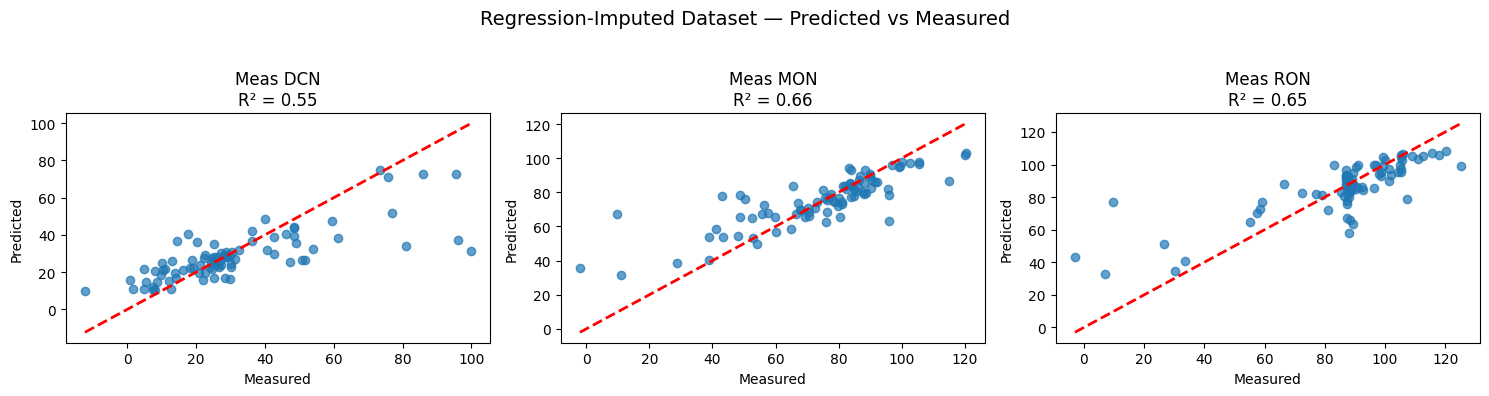

In [63]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_reg = df.copy()  # or use the name of your current working dataframe
targets = ["Meas DCN", "Meas MON", "Meas RON"]
df_reg = df_reg.dropna(subset=targets, how="all").reset_index(drop=True)

imputer = IterativeImputer(random_state=42)
df_reg[targets] = imputer.fit_transform(df_reg[targets])

print("After regression imputation:")
print(df_reg[targets].isna().sum())

X_desc = df_reg["SMILES"].apply(smiles_to_descriptors)
X = pd.DataFrame(X_desc.tolist(), columns=descriptor_names)
X = X.dropna(axis=1)

y = df_reg[targets].apply(pd.to_numeric, errors='coerce')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred_df = pd.DataFrame(model.predict(X_val), columns=targets)

print("\nPerformance on Validation Set:")
for col in targets:
    mae = mean_absolute_error(y_val[col], y_pred_df[col])
    rmse = np.sqrt(mean_squared_error(y_val[col], y_pred_df[col]))
    r2 = r2_score(y_val[col], y_pred_df[col])
    print(f"\n{col}:")
    print(f" MAE  = {mae:.3f}")
    print(f" RMSE = {rmse:.3f}")
    print(f" R²   = {r2:.3f}")

def plot_predicted_vs_measured(y_true, y_pred, targets, label):
    plt.figure(figsize=(15, 4))
    for i, col in enumerate(targets):
        plt.subplot(1, 3, i+1)
        plt.scatter(y_true[col], y_pred[col], alpha=0.7)
        plt.plot(
            [y_true[col].min(), y_true[col].max()],
            [y_true[col].min(), y_true[col].max()],
            'r--', linewidth=2
        )
        plt.xlabel("Measured")
        plt.ylabel("Predicted")
        r2 = r2_score(y_true[col], y_pred[col])
        plt.title(f"{col}\nR² = {r2:.2f}")
    plt.suptitle(f"{label} — Predicted vs Measured", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_predicted_vs_measured(y_val.reset_index(drop=True),
                           y_pred_df,
                           targets,
                           label="Regression-Imputed Dataset")


## Removing outliers

In [64]:

from scipy import stats
z_thresh = 3 

z_scores = np.abs(stats.zscore(y))
mask_no_outliers = (z_scores < z_thresh).all(axis=1)

print(f"Removed {len(y) - mask_no_outliers.sum()} outliers out of {len(y)} samples")

X = X[mask_no_outliers].reset_index(drop=True)
y = y[mask_no_outliers].reset_index(drop=True)


Removed 16 outliers out of 430 samples


Removed 16 outliers out of 430 samples


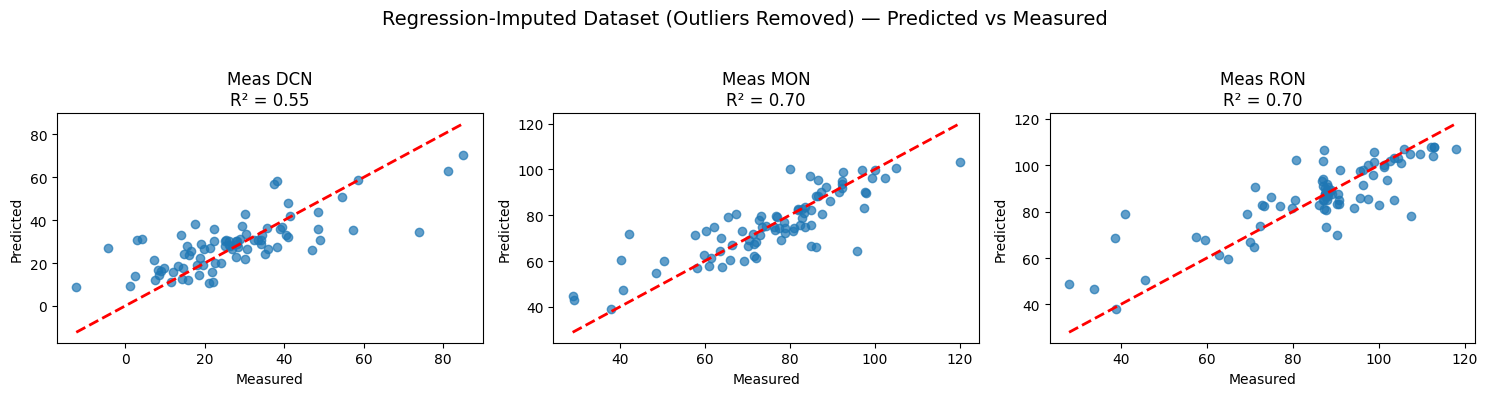

In [65]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

df_model = df_reg.dropna(subset=["Meas DCN", "Meas MON", "Meas RON"], how="all")

X_desc = df_model["SMILES"].apply(smiles_to_descriptors)
X = pd.DataFrame(X_desc.tolist(), columns=descriptor_names).dropna(axis=1)

targets = ["Meas DCN", "Meas MON", "Meas RON"]
y = df_model[targets].apply(pd.to_numeric, errors="coerce")

z_thresh = 3
z_scores = np.abs(stats.zscore(y))
mask_no_outliers = (z_scores < z_thresh).all(axis=1)

print(f"Removed {len(y) - mask_no_outliers.sum()} outliers out of {len(y)} samples")

X = X[mask_no_outliers].reset_index(drop=True)
y = y[mask_no_outliers].reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict(X_val), columns=targets)

plt.figure(figsize=(15, 4))
for i, col in enumerate(targets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_val[col], y_pred[col], alpha=0.7)
    plt.plot([y_val[col].min(), y_val[col].max()],
             [y_val[col].min(), y_val[col].max()], 'r--', linewidth=2)
    r2 = r2_score(y_val[col], y_pred[col])
    plt.xlabel("Measured")
    plt.ylabel("Predicted")
    plt.title(f"{col}\nR² = {r2:.2f}")

plt.suptitle("Regression-Imputed Dataset (Outliers Removed) — Predicted vs Measured", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Results 

In [66]:
print("R² Scores:\n", y_val.columns, [r2_score(y_val[c], y_pred[c]) for c in y_val.columns])


R² Scores:
 Index(['Meas DCN', 'Meas MON', 'Meas RON'], dtype='object') [0.5514744664220177, 0.7037235309950807, 0.6952216988492902]


In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def compute_metrics(df, meas_col, pred_col):
    mae = mean_absolute_error(df[meas_col], df[pred_col])
    rmse = np.sqrt(mean_squared_error(df[meas_col], df[pred_col]))
    r2 = r2_score(df[meas_col], df[pred_col])
    return mae, rmse, r2

for name, data, meas, pred in [
    ("DCN", df_clean_dcn, 'Meas DCN', 'Pred DCN'),
    ("MON", df_clean_mon, 'Meas MON', 'Pred MON'),
    ("RON", df_clean_ron, 'Meas RON', 'Pred RON')
]:
    mae, rmse, r2 = compute_metrics(data, meas, pred)
    print(f"\n{name} after outlier removal:")
    print(f"MAE  = {mae:.3f}")
    print(f"RMSE = {rmse:.3f}")
    print(f"R²   = {r2:.3f}")



DCN after outlier removal:
MAE  = 1.559
RMSE = 2.148
R²   = 0.955

MON after outlier removal:
MAE  = 2.859
RMSE = 3.848
R²   = 0.963

RON after outlier removal:
MAE  = 2.774
RMSE = 4.317
R²   = 0.947
